In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
from decimal import *
import MySQLdb
import pandas.io.sql as psql
from MySQLdb.converters import conversions
from MySQLdb.constants import FIELD_TYPE
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline
from math import radians, sin, cos, sqrt, asin, pi, degrees
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
import json
import scraperwiki
import scraperwiki
import json
import datetime
from __future__ import print_function

from bokeh.browserlib import view
from bokeh.document import Document
from bokeh.embed import file_html
from bokeh.models.glyphs import Circle
from bokeh.models import (
    GMapPlot, Range1d, ColumnDataSource,
    PanTool, WheelZoomTool, BoxSelectTool,
    BoxSelectionOverlay, GMapOptions)
from bokeh.resources import INLINE

def GetRecentCrimeParsed(lon,lat,radius):
  "imports recent crimes from the specified location"
  url = "http://api.spotcrime.com/crimes.json?lat="+str(lat)+"&lon="+str(lon)+"&radius="+str(radius)+"&callback=jQuery21307489185181912035_1442769040228&key=spotcrime-private-api-key&_=1442769040230"
  s = scraperwiki.scrape(url)
  parsed_json = json.loads(s.partition('(')[-1].rpartition(')')[0])
  return parsed_json

def GetRecentCrimeString(lon,lat,radius):
  "imports recent crimes from the specified location"
  url = "http://api.spotcrime.com/crimes.json?lat="+str(lat)+"&lon="+str(lon)+"&radius="+str(radius)+"&callback=jQuery21307489185181912035_1442769040228&key=spotcrime-private-api-key&_=1442769040230"
  s = scraperwiki.scrape(url)
  return (s.partition('(')[-1].rpartition(')')[0])

def WriteRecentCrimes(start,step):
    filename="recent_crimes_json_"+str(start)+"_"+str(start+step)+".txt"
    with open(filename,"a") as myfile:
        myfile.write("[")
        myfile.write('{"eanid":'+str(df.ix[start].EANHotelID)+","+
            GetRecentCrimeString(df.ix[start].Longitude,df.ix[start].Latitude,radius)[1:]+'\n')
        for index, row in df[1:].iterrows():
            myfile.write(',{"eanid":'+str(row.EANHotelID)+","+
                         GetRecentCrimeString(row.Longitude,row.Latitude,radius)[1:]+'\n')
        myfile.write("]")
    return filename

def ViolentCrimeCount(lon,lat,radius):
  crime_json=GetRecentCrimeParsed(lon=lon,lat=lat,radius=radius)
  crime_list=[]
  for crime in crime_json['crimes']:
      crime_dict={'Date': 'no date','Assault': 0, 'Burglary': 0, 'Other': 0, 'Theft': 0, 'Vandalism': 0,
                  'Arrest': 0, 'Arson': 0, 'Robbery': 0, 'Shooting':0}
      crime_dict[crime['type']] = crime_dict.get(crime['type'], 0) + 1
      crime_dict['Date'] = datetime.datetime.strptime((crime['date'])[0:8], "%m/%d/%y").date()
      crime_list.append(crime_dict)
  try:
      testdf=DataFrame(crime_list)
      testdf=testdf.groupby(by=testdf.Date).sum()
      violent_list=['Arrest','Arson','Assault','Shooting','Robbery','Vandalism']
      count=0
      for crime in violent_list:
        count += testdf[crime].sum()
  except:
      count=0
  return count



conversions[FIELD_TYPE.DECIMAL] = float
conversions[FIELD_TYPE.NEWDECIMAL] = float

conn = MySQLdb.connect(user="root", host="localhost", db='eanprod', charset='utf8',unix_socket="/tmp/mysql.sock")

Populating the interactive namespace from numpy and matplotlib


In [2]:
sql='SELECT * FROM pointsofinterestcoordinateslist WHERE RegionNameLong LIKE "%Los Angeles, California, United States of America%";'
attractions = DataFrame(psql.read_sql(sql, conn))

attractions.SubClassification[attractions.SubClassification=='anchor']='marine'
attractions.SubClassification[attractions.SubClassification=='tree']='park'
attractions.SubClassification[attractions.SubClassification=='icecream']='amusement'
attractions.SubClassification[attractions.SubClassification=='sunglass']='beach'
attractions.SubClassification[attractions.SubClassification=='civic']='cityscape'
attractions.SubClassification[attractions.SubClassification=='stadius']='sports'

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [3]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth 
    # Use 3956 for miles, 6371 for kilometers
    return c * r

In [4]:
X=attractions[:][['Latitude', 'Longitude']].values
N = X.shape[0]
distance_matrix = zeros((N, N))
for i in xrange(N):
    for j in xrange(i):
        lati, loni = X[i]
        latj, lonj = X[j]
        distance_matrix[i, j] = haversine(loni, lati, lonj, latj)
        distance_matrix[j, i] = distance_matrix[i, j]

In [18]:
# with fortran
import haver
lat_arr=attractions[:][['Latitude']].values
lon_arr=attractions[:][['Longitude']].values
distance_matrix=haver.haverM(lat_arr,lon_arr,lat_arr.shape[0])

ImportError: dlopen(./haver.so, 2): Symbol not found: _PyBytes_FromString
  Referenced from: ./haver.so
  Expected in: dynamic lookup


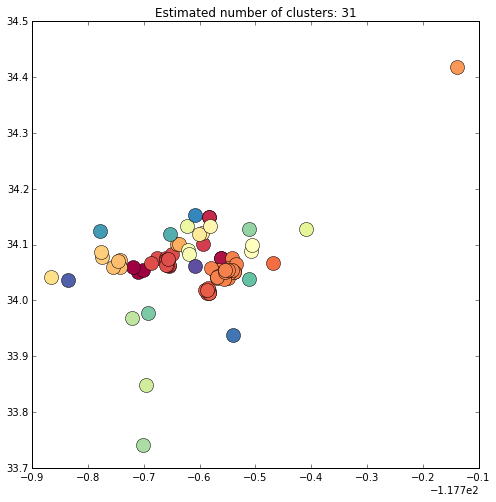

In [7]:
dbsc = DBSCAN(eps=1., min_samples=1,metric='precomputed').fit(distance_matrix)
core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)
core_samples_mask[dbsc.core_sample_indices_] = True
labels = dbsc.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(8, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [9]:
x_range = Range1d()
y_range = Range1d()

# JSON style string taken from: https://snazzymaps.com/style/1/pale-dawn
map_options = GMapOptions(lat=37.792524, lng=-122.403992, map_type="roadmap", zoom=12, styles="""
[{"featureType":"administrative","elementType":"all","stylers":[{"visibility":"on"},{"lightness":33}]},{"featureType":"landscape","elementType":"all","stylers":[{"color":"#f2e5d4"}]},{"featureType":"poi.park","elementType":"geometry","stylers":[{"color":"#c5dac6"}]},{"featureType":"poi.park","elementType":"labels","stylers":[{"visibility":"on"},{"lightness":20}]},{"featureType":"road","elementType":"all","stylers":[{"lightness":20}]},{"featureType":"road.highway","elementType":"geometry","stylers":[{"color":"#c5c6c6"}]},{"featureType":"road.arterial","elementType":"geometry","stylers":[{"color":"#e4d7c6"}]},{"featureType":"road.local","elementType":"geometry","stylers":[{"color":"#fbfaf7"}]},{"featureType":"water","elementType":"all","stylers":[{"visibility":"on"},{"color":"#acbcc9"}]}]
""")
plot = GMapPlot(
    x_range=x_range, y_range=y_range,
    map_options=map_options,
    title="SF: big clusters"
)
lat=list(X[:,0])
lon=list(X[:,1])
cluster_nn=labels
num_objects=[3,5,1]
fill=['red', 'blue', 'orange']
colors = [
    "#%02x%02x%02x" % (5+20*r, int(255/(r+1)), 250-20*r) for r in labels
]
fill=colors
source = ColumnDataSource(
    data=dict(
        lat=lat,
        lon=lon,
        fill=fill
    )
)
# colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x), np.floor(30+2*y))]
circle = Circle(x="lon", y="lat", size=15, fill_color="fill", line_color="black")
plot.add_glyph(source, circle)

pan = PanTool()
wheel_zoom = WheelZoomTool()
box_select = BoxSelectTool()

plot.add_tools(pan, wheel_zoom, box_select)
overlay = BoxSelectionOverlay(tool=box_select)
plot.add_layout(overlay)

doc = Document()
doc.add(plot)

if __name__ == "__main__":
    filename = "maps.html"
    with open(filename, "w") as f:
        f.write(file_html(doc, INLINE, "Cali_big_clust"))
    print("Wrote %s" % filename)
    view(filename)

Wrote maps.html


In [43]:
clusters_df = pd.DataFrame(columns=['ClusterNum','Latitude','Longitude'])
new_label=0
label_copy=numpy.empty_like(labels)
for cluster_num in unique_labels:
    X_c=X[labels==cluster_num]
    N_c = X_c.shape[0]
    if N_c>1:
        dist_matrix_c = distance_matrix[labels==cluster_num][:,labels==cluster_num]
        extra_clust=int(dist_matrix_c.max()/0.5)
    else:
        extra_clust=0
    nclust_k = extra_clust+1
    k_means = cluster.KMeans(n_clusters=nclust_k)
    k_means.fit(X_c)
    k_centers=k_means.cluster_centers_
    k_labels=k_means.labels_
    label_copy[labels==cluster_num]=k_labels+new_label
    for j in unique(k_labels):
        clusters_df=clusters_df.append({'ClusterNum':new_label,
                                        'Latitude':k_centers[j,0],
                                        'Longitude':k_centers[j,1]},ignore_index=True)
        new_label+=1

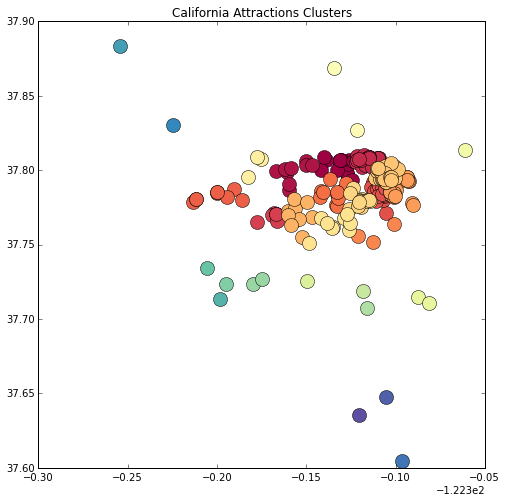

In [44]:
n_clusters_ = len(set(label_copy))
unique_labels_copy = set(label_copy)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_copy)))
plt.figure(figsize=(8, 8))
for k, col in zip(unique_labels_copy, colors):
    class_member_mask = (label_copy == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.title('California Attractions Clusters')
plt.show()

In [48]:
x_range = Range1d()
y_range = Range1d()

# JSON style string taken from: https://snazzymaps.com/style/1/pale-dawn
map_options = GMapOptions(lat=37.792524, lng=-122.403992, map_type="roadmap", zoom=12, styles="""
[{"featureType":"administrative","elementType":"all","stylers":[{"visibility":"on"},{"lightness":33}]},{"featureType":"landscape","elementType":"all","stylers":[{"color":"#f2e5d4"}]},{"featureType":"poi.park","elementType":"geometry","stylers":[{"color":"#c5dac6"}]},{"featureType":"poi.park","elementType":"labels","stylers":[{"visibility":"on"},{"lightness":20}]},{"featureType":"road","elementType":"all","stylers":[{"lightness":20}]},{"featureType":"road.highway","elementType":"geometry","stylers":[{"color":"#c5c6c6"}]},{"featureType":"road.arterial","elementType":"geometry","stylers":[{"color":"#e4d7c6"}]},{"featureType":"road.local","elementType":"geometry","stylers":[{"color":"#fbfaf7"}]},{"featureType":"water","elementType":"all","stylers":[{"visibility":"on"},{"color":"#acbcc9"}]}]
""")
plot = GMapPlot(
    x_range=x_range, y_range=y_range,
    map_options=map_options,
    title="SF: small clusters"
)
lat=list(X[:,0])
lon=list(X[:,1])
cluster_nn=labels
num_objects=[3,5,1]
fill=['red', 'blue', 'orange']
colors = [
    "#%02x%02x%02x" % (5+20*r, int(255/(r+1)), 250-20*r) for r in label_copy
]
fill=colors
source = ColumnDataSource(
    data=dict(
        lat=lat,
        lon=lon,
        fill=fill
    )
)
# colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x), np.floor(30+2*y))]
circle = Circle(x="lon", y="lat", size=15, fill_color="fill", line_color="black")
plot.add_glyph(source, circle)

pan = PanTool()
wheel_zoom = WheelZoomTool()
box_select = BoxSelectTool()

plot.add_tools(pan, wheel_zoom, box_select)
overlay = BoxSelectionOverlay(tool=box_select)
plot.add_layout(overlay)

doc = Document()
doc.add(plot)

if __name__ == "__main__":
    filename = "maps.html"
    with open(filename, "w") as f:
        f.write(file_html(doc, INLINE, "Cali_big_clust"))
    print("Wrote %s" % filename)
    view(filename)

Wrote maps.html


In [15]:
cluster_nn

array([ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  4,  0,
        0,  0,  0,  0,  0,  0,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  6,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,
        0,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,
        0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  9,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  7,  0,  0,  0,
        0, 11,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0])

In [16]:
plt.cm.Spectral(np.linspace(0, 1, len(unique(cluster_nn))))

array([[ 0.61960787,  0.00392157,  0.25882354,  1.        ],
       [ 0.79723185,  0.20092272,  0.30080739,  1.        ],
       [ 0.91395618,  0.36239908,  0.27935411,  1.        ],
       [ 0.97485583,  0.55740101,  0.32272204,  1.        ],
       [ 0.99346405,  0.74771243,  0.43529413,  1.        ],
       [ 0.99669358,  0.89750097,  0.57708576,  1.        ],
       [ 0.99807766,  0.99923107,  0.74602078,  1.        ],
       [ 0.91733949,  0.9669358 ,  0.62006923,  1.        ],
       [ 0.74771243,  0.89803922,  0.627451  ,  1.        ],
       [ 0.52733565,  0.81061131,  0.6452134 ,  1.        ],
       [ 0.32802769,  0.68050752,  0.68027684,  1.        ],
       [ 0.22652826,  0.49388699,  0.72249137,  1.        ],
       [ 0.36862746,  0.30980393,  0.63529414,  1.        ]])

In [51]:
x_range = Range1d()
y_range = Range1d()

# JSON style string taken from: https://snazzymaps.com/style/1/pale-dawn
map_options = GMapOptions(lat=37.792524, lng=-122.403992, map_type="roadmap", zoom=12, styles="""
[{"featureType":"administrative","elementType":"all","stylers":[{"visibility":"on"},{"lightness":33}]},{"featureType":"landscape","elementType":"all","stylers":[{"color":"#f2e5d4"}]},{"featureType":"poi.park","elementType":"geometry","stylers":[{"color":"#c5dac6"}]},{"featureType":"poi.park","elementType":"labels","stylers":[{"visibility":"on"},{"lightness":20}]},{"featureType":"road","elementType":"all","stylers":[{"lightness":20}]},{"featureType":"road.highway","elementType":"geometry","stylers":[{"color":"#c5c6c6"}]},{"featureType":"road.arterial","elementType":"geometry","stylers":[{"color":"#e4d7c6"}]},{"featureType":"road.local","elementType":"geometry","stylers":[{"color":"#fbfaf7"}]},{"featureType":"water","elementType":"all","stylers":[{"visibility":"on"},{"color":"#acbcc9"}]}]
""")
plot = GMapPlot(
    x_range=x_range, y_range=y_range,
    map_options=map_options,
    title="SF: no clusters"
)
lat=list(X[:,0])
lon=list(X[:,1])
cluster_nn=labels
num_objects=[3,5,1]
fill=['red', 'blue', 'orange']
colors = [
    "#%02x%02x%02x" % (5+20*r, int(255/(r+1)), 250-20*r) for r in label_copy
]
fill=colors
source = ColumnDataSource(
    data=dict(
        lat=lat,
        lon=lon,
        fill=fill
    )
)
# colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x), np.floor(30+2*y))]
circle = Circle(x="lon", y="lat", size=15, fill_color="blue", line_color="black")
plot.add_glyph(source, circle)

pan = PanTool()
wheel_zoom = WheelZoomTool()
box_select = BoxSelectTool()

plot.add_tools(pan, wheel_zoom, box_select)
overlay = BoxSelectionOverlay(tool=box_select)
plot.add_layout(overlay)

doc = Document()
doc.add(plot)

if __name__ == "__main__":
    filename = "maps.html"
    with open(filename, "w") as f:
        f.write(file_html(doc, INLINE, "Cali_big_clust"))
    print("Wrote %s" % filename)
    view(filename)

Wrote maps.html


In [5]:
conn = MySQLdb.connect(user="root", host="localhost", db='Illseeitall', charset='utf8',unix_socket="/tmp/mysql.sock")

In [72]:
user_input=['San Francisco','3','150',[u'amusement', u'beach', u'business', u'casino', u'cityscape', u'golf', u'historic', u'marine', u'medical', u'monument', u'museums', u'park',u'school',u'shopping',u'sign',u'skiing',u'stadium',u'theater',u'winery']] 
#[u'amusement', u'beach', u'business', u'casino', u'cityscape', u'golf', u'historic', u'marine', u'medical', u'monument', u'museums', u'park',u'school',u'shopping',u'sign',u'skiing',u'stadium',u'theater',u'winery']

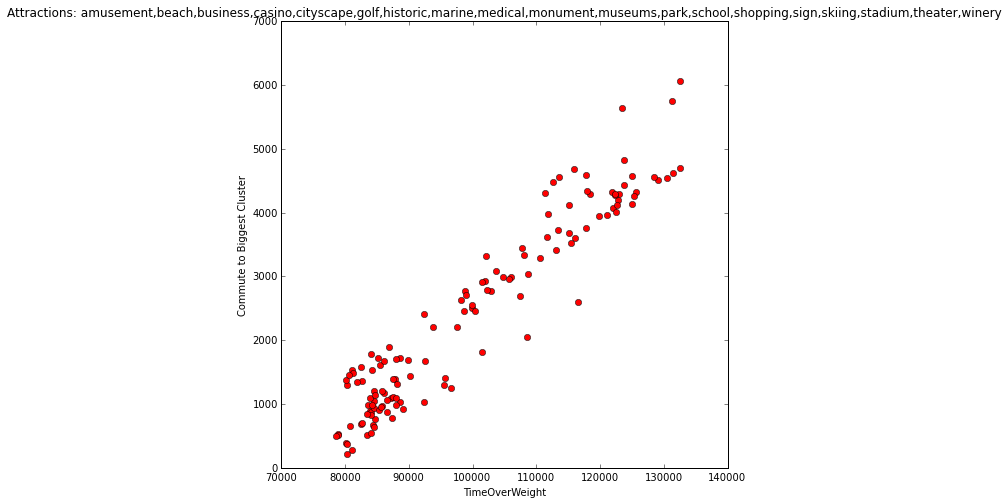

In [7]:
user_input=['Los Angeles','3','200',[u'amusement', u'beach', u'business', u'casino', u'cityscape', u'golf', u'historic', u'marine', u'medical', u'monument', u'museums', u'park',u'school',u'shopping',u'sign',u'skiing',u'stadium',u'theater',u'winery']] 

cur = conn.cursor()
sql='DROP TEMPORARY TABLE IF EXISTS temp_table;'
cur.execute(sql)
sql='CREATE TEMPORARY TABLE temp_table'+\
    ' SELECT SUM(commutetime.CommuteTime/(%s)) AS TimeOverWeight, commutetime.EANHotelID FROM clustersobjects'%('+'.join(user_input[3]))+\
    ' INNER JOIN clusters ON clustersobjects.ClusterNum=clusters.ClusterNum'+\
    ' INNER JOIN commutetime ON commutetime.ClusterNum=clusters.ClusterNum'+\
    ' WHERE clusters.City="%s" GROUP BY commutetime.EANHotelID ORDER BY TimeOverWeight;'%(user_input[0])
cur.execute(sql)
sql='SELECT hotels.EANHotelID,hotels.Name,hotels.LowRate,hotels.Latitude,hotels.Longitude,'+\
    ' hotels.StarRating,temp_table.TimeOverWeight'+\
    ' FROM hotels INNER JOIN temp_table ON temp_table.EANHotelID=hotels.EANHotelID'+\
    ' WHERE hotels.StarRating>=%s AND hotels.LowRate<=%s;'%(user_input[1],user_input[2])
hotels=DataFrame(psql.read_sql(sql, conn))

sql=' SELECT %s AS Weight, clusters.ClusterNum FROM clustersobjects'%('+'.join(user_input[3]))+\
    ' INNER JOIN clusters ON clustersobjects.ClusterNum=clusters.ClusterNum'+\
    ' WHERE clusters.City="%s" AND %s>0;'%(user_input[0],('+'.join(user_input[3])))
clusters=DataFrame(psql.read_sql(sql, conn))
biggest_cluster=clusters.ClusterNum[clusters.Weight==max(clusters.Weight)]

sql=' SELECT EANHotelID,CommuteTime FROM commutetime WHERE City="%s" AND ClusterNum=%i'%(user_input[0],int(biggest_cluster))
commute = DataFrame(psql.read_sql(sql, conn))

cur = conn.cursor()
sql='DROP TEMPORARY TABLE IF EXISTS temp_table;'
cur.execute(sql)
sql='CREATE TEMPORARY TABLE temp_table'+\
    ' SELECT SUM(commutetime.CommuteTime/(%s)) AS TimeOverWeight, commutetime.EANHotelID FROM clustersobjects'%('+'.join(user_input[3]))+\
    ' INNER JOIN clusters ON clustersobjects.ClusterNum=clusters.ClusterNum'+\
    ' INNER JOIN commutetime ON commutetime.ClusterNum=clusters.ClusterNum'+\
    ' WHERE clusters.City="%s" GROUP BY commutetime.EANHotelID ORDER BY TimeOverWeight;'%(user_input[0])
cur.execute(sql)
sql='SELECT hotels.EANHotelID,hotels.Name,hotels.LowRate,hotels.Latitude,hotels.Longitude,'+\
    ' hotels.StarRating,temp_table.TimeOverWeight'+\
    ' FROM hotels INNER JOIN temp_table ON temp_table.EANHotelID=hotels.EANHotelID;'
hotels=DataFrame(psql.read_sql(sql, conn))
df=hotels.merge(commute,on='EANHotelID')
plt.figure(figsize=(8, 8))
plt.title('Attractions: '+','.join(user_input[3]))
plt.xlabel('TimeOverWeight')
plt.ylabel('Commute to Biggest Cluster')
plt.plot(df.TimeOverWeight,df.CommuteTime, 'ro')
savefig('%s_%s.png'%(user_input[0],'+'.join(user_input[3])))

In [102]:
from __future__ import print_function
from bokeh.browserlib import view
from bokeh.document import Document
from bokeh.embed import file_html, components
from bokeh.models.glyphs import Circle
from bokeh.models import (
    GMapPlot, Range1d, ColumnDataSource,
    PanTool, WheelZoomTool, BoxSelectTool,
    BoxSelectionOverlay, GMapOptions, HoverTool,
    TapTool, OpenURL)
from bokeh.resources import INLINE
from bokeh.plotting import figure, output_file, show

# output to static HTML file
output_file("square.html")
colors = [
    "#%02x%02x%02x" % (int(r/max(df['LowRate'])*255), 150, 150) for r in list(df['LowRate'])
]
source = ColumnDataSource(
    data=dict(
        x=list(df['TimeOverWeight']),
        y=list(df['CommuteTime']),
        z=list(df['LowRate']),
        col=colors
    )
)

pan = PanTool()
wheel_zoom = WheelZoomTool()
box_select = BoxSelectTool()
hover = HoverTool(
        tooltips=[
            ("price", "@z"),
        ]
    )


plot = figure(plot_width=400, plot_height=400)
#plot.circle(hotel_prices_df['DateS'], hotel_prices_df['Price'], size=20, color="blue", alpha=0.5)

plot.add_tools(pan, wheel_zoom, box_select,hover)
overlay = BoxSelectionOverlay(tool=box_select)
plot.add_layout(overlay)

circle = Circle(x="x", y="y", size=10, fill_color="col", line_color="blue")
plot.add_glyph(source,circle)
plot.xaxis.axis_label = "Time over Weight"
plot.yaxis.axis_label = "Time to biggest cluster"
show(plot)

In [96]:
df

,EANHotelID,Name,LowRate,Latitude,Longitude,StarRating,TimeOverWeight,CommuteTime
0,105310,The Westin St Francis on Union Square,233.3756,37.78773,-122.40822,4.0,9885.154752,426
1,105656,Sheraton Fisherman's Wharf,226.8129,37.80688,-122.41380,4.0,10548.864123,851
2,106066,Grand Hyatt San Francisco Union Square,466.6240,37.78911,-122.40682,4.0,9408.339491,220
3,106067,Hyatt Regency San Francisco,317.7267,37.79372,-122.39644,4.0,8727.529585,494
4,106236,InterContinental Mark Hopkins,214.6309,37.79187,-122.41072,4.0,10465.172021,231
5,106346,Marriott San Francisco Fisherman's Wharf,179.0000,37.80561,-122.41781,3.5,10870.023963,654
6,107229,Hilton San Francisco Downtown/Financial District,430.1949,37.79503,-122.40486,4.0,10143.409103,318
7,107230,Holiday Inn Civic Center San Francisco,149.0000,37.77814,-122.41392,3.5,10721.910040,900
8,107231,Holiday Inn San Francisco-Fisherman's Wharf,307.6546,37.80603,-122.41844,3.5,10805.060107,657
9,107232,Holiday Inn Golden Gateway,214.6309,37.78986,-122.42215,3.5,12112.978983,689


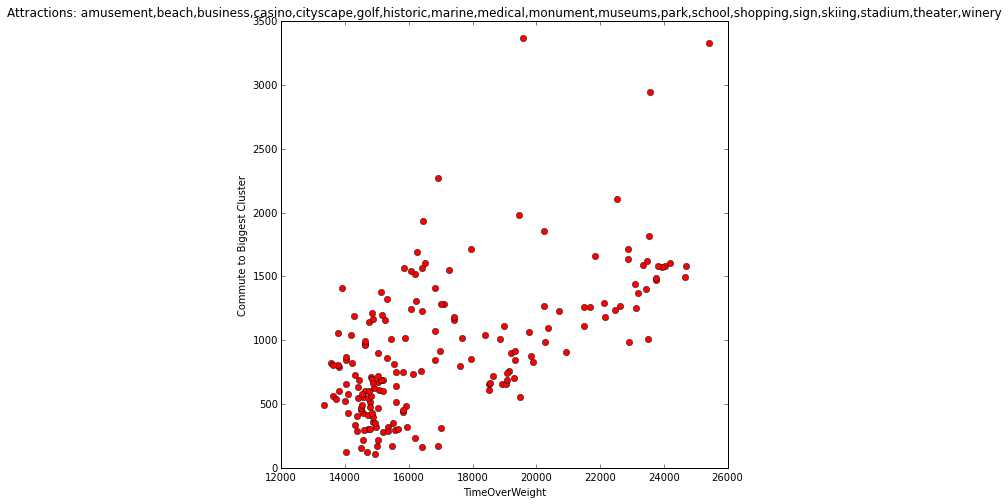

In [13]:
X

array([[  37.792524, -122.403992],
       [  37.78785 , -122.40473 ],
       [  37.787721, -122.400828],
       [  37.776498, -122.433357],
       [  37.826747, -122.421357],
       [  37.78742 , -122.4099  ],
       [  37.79751 , -122.42715 ],
       [  37.803087, -122.400926],
       [  37.787085, -122.410226],
       [  37.76359 , -122.401   ],
       [  37.868504, -122.434587],
       [  37.808245, -122.409231],
       [  37.806919, -122.425931],
       [  37.780781, -122.418627],
       [  37.778245, -122.390828],
       [  37.78824 , -122.42394 ],
       [  37.795475, -122.48271 ],
       [  37.80878 , -122.41502 ],
       [  37.75186 , -122.41239 ],
       [  37.80633 , -122.43159 ],
       [  37.81327 , -122.36138 ],
       [  37.77858 , -122.41752 ],
       [  37.80822 , -122.40995 ],
       [  37.79535 , -122.40531 ],
       [  37.76778 , -122.441533],
       [  37.794673, -122.411465],
       [  37.77027 , -122.46678 ],
       [  37.78664 , -122.40153 ],
       [  37.784987,

In [15]:
import scipy.spatial.distance as ssd

N = X.shape[0]
distance_matrix = zeros((N, N))
for i in xrange(N):
    for j in xrange(i):
        lati, loni = X[i]
        latj, lonj = X[j]
        distance_matrix[i, j] = haversine(loni, lati, lonj, latj)
        distance_matrix[j, i] = distance_matrix[i, j]
distArray = ssd.squareform(distance_matrix)
distArray

array([ 0.32521996,  0.37387038,  1.94731172, ...,  0.19865577,
        0.06587913,  0.23845207])

In [17]:
from scipy.cluster.hierarchy import fcluster,linkage

Z1=linkage(distArray,method='complete')
Z1

array([[  1.70000000e+01,   1.72000000e+02,   0.00000000e+00,
          2.00000000e+00],
       [  9.60000000e+01,   9.70000000e+01,   0.00000000e+00,
          2.00000000e+00],
       [  1.95000000e+02,   2.12000000e+02,   0.00000000e+00,
          3.00000000e+00],
       [  2.60000000e+01,   9.20000000e+01,   1.09156764e-03,
          2.00000000e+00],
       [  1.75000000e+02,   2.15000000e+02,   1.76023204e-03,
          3.00000000e+00],
       [  1.67000000e+02,   1.90000000e+02,   2.28918472e-03,
          2.00000000e+00],
       [  1.05000000e+02,   1.21000000e+02,   3.27309689e-03,
          2.00000000e+00],
       [  2.70000000e+01,   1.23000000e+02,   4.96042167e-03,
          2.00000000e+00],
       [  1.17000000e+02,   2.16000000e+02,   5.16642015e-03,
          4.00000000e+00],
       [  4.90000000e+01,   8.20000000e+01,   6.13079988e-03,
          2.00000000e+00],
       [  2.80000000e+01,   7.60000000e+01,   6.89737952e-03,
          2.00000000e+00],
       [  2.20000000e

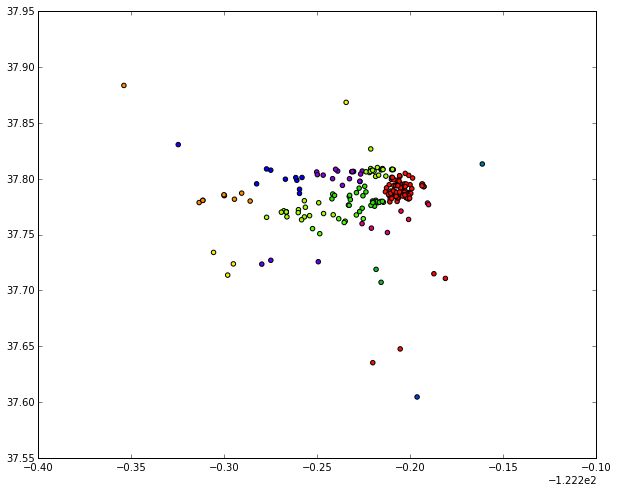

In [27]:
max_d=2
Z1=linkage(distArray,method='complete')
clusters = fcluster(Z1, max_d, criterion='distance')
clusters
plt.figure(figsize=(10, 8))
plt.scatter(X[:,1], X[:,0], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()

In [41]:
clusters-1

array([11, 11, 11, 10,  8, 11,  7, 11, 11,  9,  6,  8,  7, 10,  9, 10, 14,
        8, 18,  7, 12, 10,  8, 11, 17, 11, 17, 11, 13, 10, 13,  0,  0, 11,
       19, 10, 11, 13, 11, 11, 17, 16, 11, 10, 11, 11,  9, 14, 17, 11,  1,
        7, 11, 17, 11, 11, 11, 11, 11,  8,  7, 10,  8,  8, 11, 15,  7, 14,
       10,  8, 19, 11, 14,  4, 17, 11, 13, 11, 17, 10, 15, 19, 11, 13,  8,
       11, 11, 17, 17,  1, 10, 17, 17, 11, 10, 10, 13, 13,  9, 13, 13,  8,
       11, 11, 10,  7,  8,  5,  7, 11, 11, 18, 11,  7,  3, 18, 19, 17, 11,
        7,  8,  7, 11, 11, 17, 11, 14, 17, 10, 11, 11, 11, 10, 11, 10,  7,
        8, 11, 10, 11,  7, 14, 14,  7, 19,  8,  8,  8, 10, 10, 11,  8, 17,
       10, 11, 11,  8,  8, 11, 11, 14, 10, 11, 16, 11, 10, 15, 11, 10, 11,
       11,  2,  8, 11, 11, 17, 16, 10, 19,  8, 11, 11, 11,  8,  2, 11, 11,
       11, 19, 10, 11, 11, 10, 17, 17,  8, 14,  7, 10, 11, 11,  7,  8, 11,
       11, 11,  8, 11, 11, 11, 11, 11], dtype=int32)

In [30]:
import keys

def TransitTime(hotel_lat,hotel_lon,cluster_lat,cluster_lon):
    url="https://maps.googleapis.com/maps/api/directions/json?origin="+\
        str(hotel_lat)+","+str(hotel_lon)+\
        "&destination="+str(cluster_lat)+","+str(cluster_lon)+\
        "&mode=transit&key="+keys.google_key
    json_s=json.loads(scraperwiki.scrape(url))
    try:
        value_ret=json_s['routes'][0]['legs'][0]['duration']['value']
    except:
        value_ret=TransitTimeDrive(hotel_lat,hotel_lon,cluster_lat,cluster_lon)
    return value_ret

def TransitTimeDrive(hotel_lat,hotel_lon,cluster_lat,cluster_lon):
    url="https://maps.googleapis.com/maps/api/directions/json?origin="+\
        str(hotel_lat)+","+str(hotel_lon)+\
        "&destination="+str(cluster_lat)+","+str(cluster_lon)+\
        "&mode=driving&key="+keys.google_key
    json_s=json.loads(scraperwiki.scrape(url))
    try:
        value_ret=json_s['routes'][0]['legs'][0]['duration']['value']
    except:
        value_ret=0
    return value_ret*3

In [32]:
#TransitTime(hotel.Latitude,hotel.Longitude,cluster.Latitude,cluster.Longitude)
N = X.shape[0]
distance_matrix = zeros((N, N))
for i in xrange(N):
    for j in xrange(i):
        lati, loni = X[i]
        latj, lonj = X[j]
        distance_matrix[i, j] = TransitTime(loni, lati, lonj, latj)
        distance_matrix[j, i] = distance_matrix[i, j]
distArray = ssd.squareform(distance_matrix)
distArray

KeyboardInterrupt: 

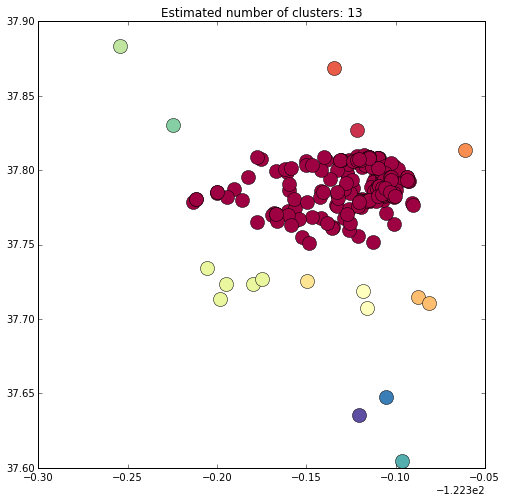

In [43]:
dbsc = DBSCAN(eps=1., min_samples=1,metric='precomputed').fit(distance_matrix)
core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)
core_samples_mask[dbsc.core_sample_indices_] = True
labels = dbsc.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(8, 8))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)
    
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [80]:
max_d=2
clusters_df = pd.DataFrame(columns=['ClusterNum','Latitude','Longitude'])
new_label=0
label_copy=numpy.empty_like(labels)
for cluster_num in unique_labels:
    X_c=X[labels==cluster_num]
    N_c = X_c.shape[0]
    if N_c>1:
        distArray = ssd.squareform(distance_matrix[labels==cluster_num][:,labels==cluster_num])
        Z1=linkage(distArray,method='complete')
        clusters = fcluster(Z1, max_d, criterion='distance')
        label_copy[labels==cluster_num]=(clusters-1)+new_label
    else:
        clusters=[1]
        label_copy[labels==cluster_num]=new_label
    new_label+=len(unique(clusters)-1)
    print (new_label)

10
11
12
13
14
15
16
17
18
19
20
21
22


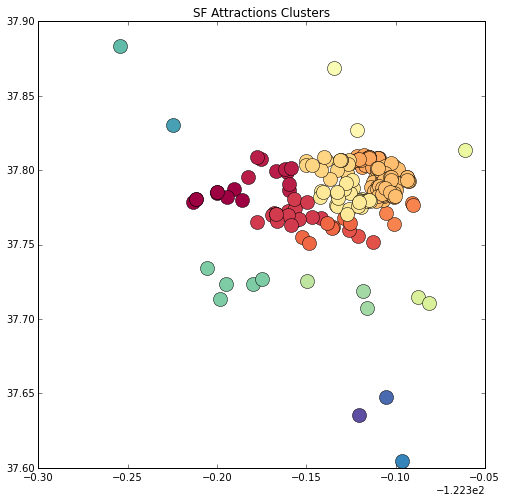

array([ 7,  7,  7,  9, 10,  7,  8,  7,  7,  5, 11,  6,  8,  9,  5,  9,  1,
        6,  3,  8, 12,  9,  6,  7,  2,  7,  2,  7,  0,  9,  0, 13, 13,  7,
        4,  9,  7,  0,  7,  7,  2, 14,  7,  9,  7,  7,  5,  1,  2,  7, 15,
        8,  7,  2,  7,  7,  7,  7,  7,  6,  8,  9,  6,  6,  7, 16,  8,  1,
        9,  6,  4,  7,  1, 17,  2,  7,  0,  7,  2,  9, 16,  4,  7,  0,  6,
        7,  7,  2,  2, 15,  9,  2,  2,  7,  9,  9,  0,  0,  5,  0,  0,  6,
        7,  7,  9,  8,  6, 18,  8,  7,  7,  3,  7,  8, 19,  3,  4,  2,  7,
        8,  6,  8,  7,  7,  2,  7,  1,  2,  9,  7,  7,  7,  9,  7,  9,  8,
        6,  7,  9,  7,  8,  1,  1,  8,  4,  6,  6,  6,  9,  9,  7,  6,  2,
        9,  7,  7,  6,  6,  7,  7,  1,  9,  7, 16,  7,  9, 16,  7,  9,  7,
        7, 20,  6,  7,  7,  2, 16,  9,  4,  6,  7,  7,  7,  6, 21,  7,  7,
        7,  4,  9,  7,  7,  9,  2,  2,  6,  1,  8,  9,  7,  7,  8,  6,  7,
        7,  7,  6,  7,  7,  7,  7,  7])

In [81]:
n_clusters_ = len(set(label_copy))
unique_labels_copy = set(label_copy)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels_copy)))
plt.figure(figsize=(8, 8))
for k, col in zip(unique_labels_copy, colors):
    class_member_mask = (label_copy == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    
plt.title('SF Attractions Clusters')
plt.show()
label_copy

In [68]:
def to_codebook(X, part):
    """
    Calculates centroids according to flat cluster assignment

    Parameters
    ----------
    X : array, (n, d)
        The n original observations with d features

    part : array, (n)
        Partition vector. p[n]=c is the cluster assigned to observation n

    Returns
    -------
    codebook : array, (k, d)
        Returns a k x d codebook with k centroids
    """
    codebook = []

    for i in range(part.min(), part.max()+1):
        codebook.append(X[part == i].mean(0))

    return np.vstack(codebook)

In [82]:
to_codebook(X, label_copy)

array([[  37.78274478, -122.50098489],
       [  37.79891244, -122.46697711],
       [  37.77011767, -122.46054867],
       [  37.755827  , -122.419808  ],
       [  37.76073057, -122.43788186],
       [  37.77242875, -122.396797  ],
       [  37.80737142, -122.41636021],
       [  37.79026805, -122.40502324],
       [  37.8034545 , -122.43558394],
       [  37.78108636, -122.42538232],
       [  37.826747  , -122.421357  ],
       [  37.868504  , -122.434587  ],
       [  37.81327   , -122.36138   ],
       [  37.712837  , -122.3843125 ],
       [  37.725693  , -122.449558  ],
       [  37.71305   , -122.417145  ],
       [  37.7244056 , -122.4908692 ],
       [  37.88365   , -122.55406   ],
       [  37.83065   , -122.52486   ],
       [  37.604512  , -122.396439  ],
       [  37.64756   , -122.40552   ],
       [  37.635216  , -122.420255  ]])

In [84]:
clusters_df = pd.DataFrame(columns=['ClusterNum','Latitude','Longitude'])
for i in range(label_copy.min(), label_copy.max()+1):
    center=X[label_copy == i].mean(0)
    clusters_df=clusters_df.append({'ClusterNum':i,
                                        'Latitude':center[0],
                                        'Longitude':center[1]},ignore_index=True)

In [85]:
clusters_df

,ClusterNum,Latitude,Longitude
0,0,37.782745,-122.500985
1,1,37.798912,-122.466977
2,2,37.770118,-122.460549
3,3,37.755827,-122.419808
4,4,37.760731,-122.437882
5,5,37.772429,-122.396797
6,6,37.807371,-122.416360
7,7,37.790268,-122.405023
8,8,37.803455,-122.435584
9,9,37.781086,-122.425382


In [86]:
x_range = Range1d()
y_range = Range1d()

# JSON style string taken from: https://snazzymaps.com/style/1/pale-dawn
map_options = GMapOptions(lat=37.792524, lng=-122.403992, map_type="roadmap", zoom=12, styles="""
[{"featureType":"administrative","elementType":"all","stylers":[{"visibility":"on"},{"lightness":33}]},{"featureType":"landscape","elementType":"all","stylers":[{"color":"#f2e5d4"}]},{"featureType":"poi.park","elementType":"geometry","stylers":[{"color":"#c5dac6"}]},{"featureType":"poi.park","elementType":"labels","stylers":[{"visibility":"on"},{"lightness":20}]},{"featureType":"road","elementType":"all","stylers":[{"lightness":20}]},{"featureType":"road.highway","elementType":"geometry","stylers":[{"color":"#c5c6c6"}]},{"featureType":"road.arterial","elementType":"geometry","stylers":[{"color":"#e4d7c6"}]},{"featureType":"road.local","elementType":"geometry","stylers":[{"color":"#fbfaf7"}]},{"featureType":"water","elementType":"all","stylers":[{"visibility":"on"},{"color":"#acbcc9"}]}]
""")
plot = GMapPlot(
    x_range=x_range, y_range=y_range,
    map_options=map_options,
    title="SF: small clusters"
)
lat=list(X[:,0])
lon=list(X[:,1])
cluster_nn=labels
num_objects=[3,5,1]
fill=['red', 'blue', 'orange']
colors = [
    "#%02x%02x%02x" % (5+20*r, int(255/(r+1)), 250-20*r) for r in label_copy
]
fill=colors
source = ColumnDataSource(
    data=dict(
        lat=lat,
        lon=lon,
        fill=fill
    )
)
# colors = ["#%02x%02x%02x" % (r, g, 150) for r, g in zip(np.floor(50+2*x), np.floor(30+2*y))]
circle = Circle(x="lon", y="lat", size=15, fill_color="fill", line_color="black")
plot.add_glyph(source, circle)

pan = PanTool()
wheel_zoom = WheelZoomTool()
box_select = BoxSelectTool()

plot.add_tools(pan, wheel_zoom, box_select)
overlay = BoxSelectionOverlay(tool=box_select)
plot.add_layout(overlay)

doc = Document()
doc.add(plot)

if __name__ == "__main__":
    filename = "maps.html"
    with open(filename, "w") as f:
        f.write(file_html(doc, INLINE, "Cali_big_clust"))
    print("Wrote %s" % filename)
    view(filename)

Wrote maps.html
